# Set up 

In [1]:
import math
import random
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from scipy.optimize import minimize
import seaborn as sns
sns.set(style='ticks', context='paper')
colors=["#e3c934","#68c4bf","#c51000","#287271"]
sns.set_palette(colors)

## Library 

In [2]:
def barkbark(cloud,formants,formantchar='F'):
    # cloud = exemplar cloud, dataframe
    # formants = list of formants to be converted (e.g. ["F1","F2"])
    # formantchar = prefix on all formants (e.g. for "f1, f2, f3", use formantchar='f')
    
    # Make a copy of the cloud
    newcloud=cloud.copy()
    
    # For each formant listed, make a copy of the column prefixed with z
    for formant in formants:
        name = str(formant).replace(formantchar,'z')
        
        # Convert each value from Hz to Bark
        newcloud[name] = 26.81/ (1+ 1960/newcloud[formant]) - 0.53
    # Return the dataframe with the changes
    return newcloud

In [3]:
def activation(testset,cloud,dims = {'F0':4,'F1':2,'F2':3,'F3':1},c=0.01):
    # Get stuff ready                                                   
    dims.update((x, (y/sum(dims.values()))) for x, y in dims.items())   # Normalize weights to sum to 1
    
    # If the testset happens to have N in it, remove it before joining dfs 
    test=testset.copy()
    if 'N' in test.columns:
        test = test.drop(columns='N', axis=1,inplace=True)
    
    exemplars=cloud.copy()

    # Merge test and exemplars
    bigdf = pd.merge(
        test.assign(key=1),         # Add column named 'key' with all values == 1
        exemplars.assign(key=1),    # Add column named 'key' with all values == 1
        on='key',                   # Match on 'key' to get cross join (cartesian product)
        suffixes=['_t', '_ex']
    ).drop('key', axis=1)           # Drop 'key' column
    
    
    dimensions=list(dims.keys())                # Get dimensions from dictionary
    weights=list(dims.values())                 # Get weights from dictionary
    tcols = [f'{d}_t' for d in dimensions]      # Get names of all test columns
    excols = [f'{d}_ex' for d in dimensions]    # Get names of all exemplar columns
    
    
    # Multiply each dimension by weights
    i = bigdf.loc[:, tcols].values.astype(float)     # Get all the test columns
    i *= weights                                     # Multiply test columns by weight
    j = bigdf.loc[:, excols].values.astype(float)    # Get all the exemplar columns
    j *= weights                                     # Multiply exemplar columns by weights
    
    # Get Euclidean distance
    bigdf['dist'] = np.sqrt(np.sum((i-j)**2, axis=1))
    
    # get activation: exponent of negative distance * sensitivity c, multiplied by N_j
    bigdf['a'] = np.exp(-bigdf.dist*c)*bigdf.N
    
    return bigdf
    

In [4]:
def exclude(cloud, test, exclude_self=True, alsoexclude=None):    
    # cloud = exemplars, dataframe
    # test = exemplar to be categorized
    # exclude_self = true or false, should the exemplar not be compared to itself? default true
    # alsoexclude = a list of columns in cloud to also exclude
    
    # Make a copy of the cloud and call it exemplars. 
    #    This is what we'll return at the end
    exemplars = cloud.copy()
    
    # Remove the stimulus from the cloud
    if exclude_self == True:
        exemplars=cloud[~cloud.isin(test)].dropna()  
    
    if alsoexclude != None:
        for feature in alsoexclude:
            featval=test[feature].iloc[0]
            exclude_exemps=exemplars[ exemplars[feature] == featval ].index
            exemplars.drop(exclude_exemps, inplace=True)
        
    return exemplars

In [5]:
def reset_N(exemplars, N=1):      # Add or override N, default to 1
    exemplars['N'] = N
    return exemplars

In [6]:
def bias_N(exemplars, catbias): 
    exemplars['N'] = exemplars['N'] * cltemp[cat].map(bias)
    return exemplars

In [7]:
def probs(bigdf,cats):
    prs = {}
    
    # Loop over every category in the list of categories
    for cat in cats: 
        # make that category match the exemplar category in name
        label = cat+'_ex'
        # Sum up activation for every label within that category
        cat_a = bigdf.groupby(label).a.sum()
        # Divide the activation for each label by the total activation for that category
        pr = cat_a/sum(cat_a)
        # rename a for activation to probability
        pr = pr.rename_axis(cat).reset_index().rename(columns={"a":"probability"})
        # add this to the dictionary 
        prs[cat]=pr
    return prs
    

In [8]:
def choose(pr,test,cats,runnerup=False):
    newtest = test.copy()

    for cat in cats:
        choicename = cat + 'Choice'
        choiceprobname = cat + 'Prob'
        
        best2 = pr[cat]['probability'].nlargest(n=2).reset_index(drop=True)        # Get the two highest probs for each cat type
        
        choiceprob = best2[0]                                                      # Match the prob to the category
        choice = pr[cat].loc[pr[cat]['probability']==choiceprob,cat].iloc[0]
        
        newtest[choicename] = choice
        newtest[choiceprobname] = choiceprob
        
        if runnerup == True: 
            choice2name = cat + 'Choice2'
            choice2probname = cat +'Choice2Prob'
            choice2prob = best2[1]                                                      
            choice2 = pr[cat].loc[pr[cat]['probability']==choice2prob,cat].iloc[0]
            newtest[choice2name] = choice2
            newtest[choice2probname] = choice2prob
            
    return newtest

In [9]:
def gettestset(cloud,balcat,n):     #Gets n number of rows per cat in given cattype
    testlist=[]
    for cat in list(cloud[balcat].unique()):
        samp = cloud[cloud[balcat]==cat].sample(n)
        testlist.append(samp)
    test=pd.concat(testlist)
    return test

In [10]:
def categorize(cloud,testset,cats,dims,c,exclude_self=True,alsoexclude=None):
    test=testset
    exemplars=exclude(cloud,test,exclude_self=exclude_self,alsoexclude=alsoexclude)
    reset_N(exemplars)
    bigdf=activation(test,exemplars,dims=dims,c=c)
    pr=probs(bigdf,cats)
    choices=choose(pr,test,cats)
    return choices 
    

In [11]:
def getactiv(activation,x,y,cat):
    xname = x + "_ex"
    yname = y + "_ex"
    catname = cat + "_ex"
    
    acts = activation['a']
    xs = activation[xname]
    ys = activation[yname]
    cats = activation[catname]
    
    activ = pd.concat([acts,xs,ys,cats], axis=1)
    activ.rename(columns={xname:x, yname:y, catname:cat}, inplace=True)
    
    return activ
    
    

In [12]:
def activplot(a,x,y,cat, test):
    pl = sns.scatterplot(data=a,x=x,y=y,hue=cat,size='a',size_norm=(0,a.a.max()),
                     alpha=0.5,sizes=(5,100),legend=False)
    pl = sns.scatterplot(data=test, x=x,y=y,alpha=.5,color='darkblue',marker="X", s= 50, legend=False)
    pl.invert_xaxis()
    pl.invert_yaxis()

    return pl

In [13]:
def multicat(cloud,testset,cats,dims,c,exclude_self=True,alsoexclude=None):
    choicelist=[]
    for ix in list(testset.index.values):
        test = testset.loc[[ix,]]
        exemplars=exclude(cloud,test,exclude_self=exclude_self,alsoexclude=alsoexclude)
        reset_N(exemplars)
        bigdf=activation(test,exemplars,dims = dims,c=c)
        pr=probs(bigdf,cats)
        choices = choose(pr,test,cats)
        choicelist.append(choices)
    choices=pd.concat(choicelist, ignore_index=True)
    return choices

In [14]:
def checkaccuracy(choices,cats):
    acc = choices.copy()                     # Make a copy of choices to muck around with
    
    for cat in cats:                     # Iterate over your list of cats
        accname = cat + 'Acc'            # Get the right column names
        choicename = cat + 'Choice'
        
        # If choice is the same as intended, acc =y, else n
        acc[accname] = np.where(acc[cat]==acc[choicename], 'y', 'n')      
    return acc

In [15]:
def propcorr(acc,cat):
    perc = dict(acc.groupby(cat)[cat+'Acc'].value_counts(normalize=True).drop(labels='n',level=1).reset_index(level=1,drop=True))
    pc=pd.DataFrame.from_dict(perc, orient='index').reset_index()
    pc.columns=[cat,'propcorr']
    return pc

In [16]:
def overallacc(acc,cat):
    totalcorrect = acc[cat+'Acc'].value_counts(normalize=True)['y']
    return totalcorrect

In [17]:
# Description

def accplot(pc,cat,acc):
    obs=str(len(acc))
    pl = sns.barplot(x=cat,y='propcorr',data=pc,palette=colors)
    plt.ylim(0,1.01)
    pl.set(ylabel='Proportion accurate of '+obs+' trials')
    pl.set_xticklabels(
    pl.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
    plt.show()
    return pl

In [18]:
def continuum (start,end,cloud,dimlist = ['F0','F1','F2','F3'],steps=7,df=False):
    vals = {}
    norms = {}
    rowlist = []
    
    st=cloud[cloud['vowel'] == start].sample().reset_index(drop=True) # randomly sample a row with the some start vowel
    spkr = st.speaker.iloc[0]                                         # Get the speaker and gender
    gen = st.gender.iloc[0]
    en=pb52[(cloud.speaker==spkr) & (cloud['vowel']==end)].sample().reset_index(drop=True)  # get a row with the end vowel from same speaker


    for dim in dimlist:                      # Calculate the difference between start and end for each dim
        norms[dim] = en[dim] - st[dim]                               

    for i in range (0,steps):
        for dim in dimlist: 
            vals[dim] = st[dim] + (norms[dim] * i/(steps-1))    # the values for each dim = start val + diff by step
            row = pd.DataFrame(vals)
            row['vowel'] = '?'
            row['speaker'] = spkr
            row['gender'] = gen
        rowlist.append(row)

    rowlist[0]['vowel'] = start                                   # Change start and end vowels
    rowlist[-1]['vowel'] = end
    cont=pd.concat(rowlist,ignore_index=True)             # concatenate

    if df == True:
        return cont
    else:
        return rowlist

In [19]:
def FCN(exemplars,start,end):
    exemplars['N'] = np.where((exemplars['vowel']==start)|(exemplars['vowel']==end), 1, 0)
    return exemplars

## Include other speaker characteristics 

In [20]:
def choosecontinuum(cont,cloud,cats,start,end,FC=False):
    exemplars=cloud.copy()
    exemplars=exemplars[~exemplars.isin(cont)].dropna()
    choicelist = []
    for row in cont: 
        test=row
        if FC == True:
            FCN(exemplars,start,end)
        else:
            reset_N(exemplars)
        bigdf=activation(test,exemplars)
        pr=probs(bigdf,cats)
        choices=choose(pr,test,cats)
        choicelist.append(choices)
    choices=pd.concat(choicelist,ignore_index=True)
    return choices
        

In [21]:
def multiaccplot(choices,cats):
    accuracy = checkaccuracy(choices,cats)
    for cat in cats:
        proportion = propcorr(accuracy,cat)
        accplot(proportion,cat,accuracy)
        print(proportion)

In [22]:
def confusion(choices,cats):
    matrices={}
    for cat in cats:
        matrices[cat]=pd.crosstab(choices[cat],choices[cat+'Choice'],normalize='index').round(2).rename_axis(None)
    return matrices

## data

In [23]:
pb52=pd.read_csv('pb52.csv')

In [24]:
pbbark = barkbark(pb52,["F0","F1","F2","F3"])

# For paper


In [32]:
# Set parameters
cval=5
dimsvals={'z0':1,'z1':2.953,'z2':.924,'z3':3.420}
catslist=['vowel','type']
pbtest=pbbark.copy()
test=pbbark.sample()

In [39]:
reset_N(pbtest)
exem=exclude(pbtest, test, exclude_self=True) 
a = activation(test,exem,dims = dimsvals,c=cval)

In [40]:
b=getactiv(a,"z2","z1","vowel")

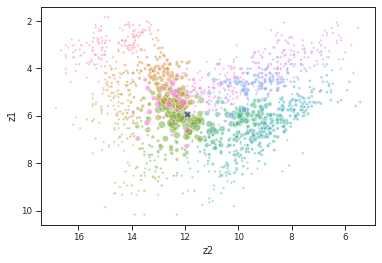

In [41]:
activplot(b,"z2",'z1','vowel',test=test)

In [42]:
test

,type,gender,speaker,vowel,repetition,F0,F1,F2,F3,z0,z1,z2,z3
187,m,m,10,TRAP,2,120,624,1700,2475,1.016731,5.944241,11.922732,14.431612


In [44]:
b

,a,z2,z1,vowel
0,0.005399,13.886698,2.394727,FLEECE
1,0.009431,14.227798,2.821250,FLEECE
2,0.057053,13.110175,3.919319,KIT
3,0.029969,12.943046,3.131278,KIT
4,0.228457,12.560000,4.832000,DRESS
...,...,...,...,...
1514,0.002264,11.309174,5.833463,FOOT
1515,0.001341,9.910031,5.091452,GOOSE
1516,0.001790,9.329161,4.919187,GOOSE
1517,0.050586,12.487979,6.817926,NURSE
